# Look at climate change in CESM

## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import os
import cartopy.util
import copy

# Import custom modules
import src.utils
from src.XRO import XRO, xcorr

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [ ]:
def plot_hov(ax, data, amp, label=None):
    """Plot hovmoller of longitude vs. year"""

    # kwargs = dict(levels=src.utils.make_cb_range(3, 0.3), cmap="cmo.balance", extend="both")
    plot_data = ax.contourf(
        data.longitude,
        data.year,
        data.T,
        cmap="cmo.balance",
        extend="both",
        levels=src.utils.make_cb_range(amp, amp / 10),
    )
    cb = fig.colorbar(
        plot_data, orientation="horizontal", ticks=[-amp, 0, amp], label=label
    )

    ## label
    kwargs = dict(ls="--", c="w", lw=0.8)
    for ax in axs:
        ax.set_xlabel("Longitude")
        ax.set_xticks([190, 240])
        ax.set_yticks([])
        ax.axvline(190, **kwargs)
        ax.axvline(240, **kwargs)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    return


def plot_hov2(ax, data, amp, label=None):
    """Plot hovmoller of longitude vs. year"""

    # kwargs = dict(levels=src.utils.make_cb_range(3, 0.3), cmap="cmo.balance", extend="both")
    plot_data = ax.contourf(
        data.month,
        data.year,
        data.T,
        cmap="cmo.balance",
        extend="max",
        levels=src.utils.make_cb_range(amp, amp / 10),
    )
    cb = fig.colorbar(
        plot_data,
        orientation="horizontal",
        ticks=[-amp, 0, amp],
        label=label,
        # plot_data, orientation="horizontal", ticks=[], label=None
    )

    ## label
    kwargs = dict(ls="--", c="w", lw=0.8)
    for ax in axs:
        # ax.set_xlabel("Month")
        # ax.set_xticks([1, 12])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    return


def get_rolling_var(data, n=10):
    """
    Get variance, computing over time and ensemble member. To increase
    sample size for variance estimate, compute over time window of 2n+1
    years, centered at given year.
    """

    return src.utils.get_rolling_fn_bymonth(data, fn=np.var, n=n)

## Change in $T$, $h$

### Load data
And compute variance/skewness

In [ ]:
## load ELI data
eli = xr.open_dataset(pathlib.Path(DATA_FP, "cesm/eli.nc"))

## get forced/anomalous component
eli_forced, eli_anom = src.utils.separate_forced(eli)

In [ ]:
## open data
Th = src.utils.load_cesm_indices()

## rename indices for convenience
Th = Th.rename(
    {
        "north_tropical_atlantic": "natl",
        "atlantic_nino": "nino_atl",
        "tropical_indian_ocean": "iobm",
        "indian_ocean_dipole": "iod",
        "north_pacific_meridional_mode": "npmm",
        "south_pacific_meridional_mode": "spmm",
    }
)

## add ELI data
# Th = xr.merge([Th, eli_anom["eli_15"]])

## get rolling variance, by month
Th_var = get_rolling_var(Th, n=15)
Th_var_bymonth = src.utils.unstack_month_and_year(Th_var)

## get rolling skew, by month
Th_skew = src.utils.get_rolling_fn_bymonth(Th, fn=scipy.stats.skew, n=15)
Th_skew_bymonth = src.utils.unstack_month_and_year(Th_skew)

## Get % increase in variance
baseline = Th_var_bymonth.isel(year=slice(None, 30)).mean("year")
Th_var_bymonth_pct = 100 * (Th_var_bymonth - baseline) / baseline

### Variance

Hövmöller

In [ ]:
## setup plot
fig, axs = plt.subplots(
    1, len(list(Th)), figsize=(0.9 * len(list(Th)), 2), layout="constrained"
)

## plot T data
for ax, n in zip(axs, list(Th)):
    plot_hov2(ax, Th_var_bymonth_pct[n].T, amp=100)
    ax.set_title(n, fontsize=9)
    ax.axvline(8, ls="--", c="w", lw=1)


plt.show()

Compare August and December variance over time

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 2))

## plot data
ax.plot(
    Th_var_bymonth.year, Th_var_bymonth["T_34"].sel(month=8), label="Aug", c="k", ls="-"
)
ax.plot(
    Th_var_bymonth.year,
    Th_var_bymonth["T_34"].sel(month=11),
    label="Dec",
    c="gray",
    ls="--",
)

## label and style
ax.set_title(r"$\sigma^2\left(\text{Niño 3.4}\right)$")
ax.set_ylim([0, None])
ax.legend(prop=dict(size=8))
ax.set_ylabel(r"$^{\circ}\text{C}^2$")

plt.show()

### Skewness

In [ ]:
## setup plot
fig, axs = plt.subplots(1, 5, figsize=(7.2, 4), layout="constrained")

## plot T data
for i, n in enumerate(["T_4", "T_34", "T_3", "h", "h_w"]):
    plot_hov2(axs[i], Th_skew_bymonth[n].T, amp=1.5)
    axs[i].set_title(n, fontsize=9)
    axs[i].axvline(5, ls="--", c="w", lw=1, alpha=0.5)

plt.show()

### ELI

In [ ]:
## get mean by month (smoothed)
eli_mean_bymonth = src.utils.unstack_month_and_year(eli_forced)
eli_mean_bymonth = src.utils.get_rolling_avg(eli_mean_bymonth, n=15, dim="year")
delta_eli = eli_mean_bymonth - eli_mean_bymonth.isel(year=0)

## get rolling variance, by month
eli_var = get_rolling_var(eli_anom, n=15)
eli_var_bymonth = src.utils.unstack_month_and_year(eli_var)

## Get % increase in variance
baseline = eli_var_bymonth.isel(year=slice(None, 30)).mean("year")
eli_var_bymonth = 100 * (eli_var_bymonth - baseline) / baseline

## get rolling skew, by month
eli_skew = src.utils.get_rolling_fn_bymonth(eli_anom, fn=scipy.stats.skew, n=15)
eli_skew_bymonth = src.utils.unstack_month_and_year(eli_skew)

In [ ]:
## specify which ELI index to plot
eli_idx = "eli_05"

## setup plot
fig, axs = plt.subplots(1, 3, figsize=(3.16, 3), layout="constrained")

## plot mean
plot_hov2(axs[0], delta_eli[eli_idx].T, amp=15)
plot_hov2(axs[1], eli_var_bymonth[eli_idx].T, amp=300)
plot_hov2(axs[2], eli_skew_bymonth[eli_idx].T, amp=3)

## label
kwargs = dict(size=8)
axs[0].set_title(r"$\Delta$ mean", **kwargs)
axs[1].set_title(r"$\Delta$ variance (%)", **kwargs)
axs[2].set_title("skew", **kwargs)

plt.show()

### stats

In [ ]:
## get data for histogram
y = Th["T_34"]
# y = eli_anom["eli_05"]

## specify month idx
m_idx = 12

if "eli" in y.name:
    edges = np.arange(-64, 68, 4)
    tick_kwargs = dict(ticks=[-50, 0, 50], labels=["-50", "median", "+50"])
    # edges = np.arange(-25,27.5, 2.5)

elif "h" in y.name:
    edges = np.arange(-10e-2, 11e-2, 1e-2)

else:
    edges = np.arange(-4, 4.25, 0.25)
    tick_kwargs = dict(ticks=[-3, 0, 3], labels=["-3", "median", "+3"])


## get data
y0 = y.isel(time=slice(m_idx, 600, 12)).values.flatten()
y1 = y.isel(time=slice(-600 + m_idx, None, 12)).values.flatten()

## compute pdfs
pdf0, _ = src.utils.get_empirical_pdf(
    y0,
    edges=edges,
)
pdf1, _ = src.utils.get_empirical_pdf(
    y1,
    edges=edges,
)

## compute skewness
s0 = scipy.stats.skew(y0)
s1 = scipy.stats.skew(y1)

fig, ax = plt.subplots(figsize=(4, 3))
ax.stairs(pdf0, edges - np.median(y0), label=f"early: skew = {s0:.2f}")
ax.stairs(pdf1, edges - np.median(y1), label=f"late: skew = {s1:.2f}")
ax.axvline(0, c="k", lw=1)
ax.legend(prop=dict(size=8))
ax.set_xticks(**tick_kwargs)

plt.show()

## Change in spatial patterns

In [ ]:
## path to EOF data
eofs_fp = pathlib.Path(DATA_FP, "cesm")

## variables to load (and how to rename them)
names = ["tos", "zos", "tauu", "nhf", "mlotst"]
newnames = ["sst", "ssh", "taux", "nhf", "mld"]

# ## load the EOFs
load_var = lambda x: src.utils.load_eofs(pathlib.Path(eofs_fp, f"eofs_{x}.nc"))
eofs = {y: load_var(x) for (y, x) in zip(newnames, names)}

## for convenience, put spatial patterns / components in single dataset
components = xr.merge([eofs_.components().rename(y) for (y, eofs_) in eofs.items()])

# reset member dimension so they all match (NHF labeled differently...)
member_coord = dict(member=np.arange(100))
get_scores = lambda x, n: x.scores().assign_coords(member_coord).rename(n)
scores = xr.merge([get_scores(eofs_, n) for (n, eofs_) in eofs.items()])

## convert ssh from m to cm
scores["ssh"].values *= 100

## convert from stress on atm to stress on ocn
scores["taux"].values *= -1

## get forced/anomalous component
forced, anom = src.utils.separate_forced(scores)

### Change in mean

In [ ]:
def recon_clim(data, components, varname="sst"):
    """reconstruct climatology for data"""

    ## get climatolgoy in PC space
    monthly_clim = data.groupby("time.month").mean()

    ## function to compute equatorial mean
    equatorial_mean = lambda x: x.sel(latitude=slice(-2, 2)).mean("latitude")

    ## reconstruct
    recon = src.utils.reconstruct_fn(
        components[varname], monthly_clim[varname], fn=equatorial_mean
    )

    ## fill zero values with NaN
    recon.values[recon.values == 0] = np.nan

    return recon


def get_monthly_eli(t_bnds):

    ## get eli for period
    eli_ = eli_forced.isel(time=slice(*t_bnds)).groupby("time.month").mean()

    return eli_


def get_monthly_eli_std(t_bnds):

    ## get eli for period
    eli_ = (
        eli_anom.isel(time=slice(*t_bnds)).groupby("time.month").std(["time", "member"])
    )

    return eli_


def plot_cyclic(ax, data, sigma=None, **kwargs):
    """plot data on hovmoller with cyclic dependence on month"""

    ## add cyclic point
    data_cyclic, dim_cyclic = cartopy.util.add_cyclic_point(data, data.month, axis=0)

    ## plot data
    ax.plot(data_cyclic, dim_cyclic, **kwargs)

    ## plot bounds if they exist
    if sigma is not None:
        sigma_cyclic, _ = cartopy.util.add_cyclic_point(sigma, data.month, axis=0)

        ## plot data
        ax.plot(data_cyclic + sigma_cyclic, dim_cyclic, **kwargs, lw=0.8)
        ax.plot(data_cyclic - sigma_cyclic, dim_cyclic, **kwargs, lw=0.8)

    return


def plot_cyclic_quantiles(ax, data, quantiles=[0.5, 0.15, 0.85], **kwargs):
    """plot data on hovmoller with cyclic dependence on month"""

    ## compute quantiles
    q = data.groupby("time.month").quantile(q=quantiles, dim=["time", "member"])
    # q = q.rename({"quantile":"q"})

    ## convert to numpy
    month = q.month.values
    q = q.transpose("quantile", "month").values

    ## add cyclic point
    q_cyclic, dim_cyclic = cartopy.util.add_cyclic_point(q, month, axis=1)

    ## plot median
    ax.plot(q_cyclic[0], dim_cyclic, **kwargs)

    ## plot other quantiles
    if len(quantiles) > 1:
        for j in range(1, len(quantiles)):
            ax.plot(q_cyclic[j], dim_cyclic, lw=0.8, **kwargs)

    return

#### Computation

In [ ]:
## compute clims
clim_early = recon_clim(forced.isel(time=slice(None, 360)), components)
clim_late = recon_clim(forced.isel(time=slice(-360, None)), components)

## get difference
clim_diff = clim_late - clim_early

## compute ELI
eli_early = eli.isel(time=slice(None, 360))
eli_late = eli.isel(time=slice(-360, None))

#### Plot

In [ ]:
## specify which ELI index to plot
ELI = "eli_05"

## make hövmöllers
fig, axs = plt.subplots(3, 1, figsize=(3.5, 5), layout="constrained")

## kwargs
kwargs = dict(cmap="cmo.thermal", levels=np.arange(23, 32), extend="both")

## plot early
cp0 = src.utils.plot_cycle_hov(axs[0], clim_early, **kwargs)

## plot late
kwargs["levels"] = kwargs["levels"] + 3
cp1 = src.utils.plot_cycle_hov(axs[1], clim_late, **kwargs)

## plot bias
cp2 = src.utils.plot_cycle_hov(
    axs[2],
    clim_diff,
    cmap="cmo.amp",
    levels=np.arange(2.6, 5.2, 0.2),
    extend="both",
)

## plot eli
plot_cyclic_quantiles(ax=axs[0], data=eli_early[ELI], c="w")
plot_cyclic_quantiles(ax=axs[1], data=eli_late[ELI], c="k")
plot_cyclic_quantiles(ax=axs[2], data=eli_early[ELI], c="w")
plot_cyclic_quantiles(ax=axs[2], data=eli_late[ELI], c="k")
# plot_cyclic(ax=axs[0], data=eli_early[ELI], sigma=eli_std_early[ELI], c="w")
# plot_cyclic(ax=axs[1], data=eli_late[ELI], sigma=eli_std_late[ELI], c="w", ls="--")
# plot_cyclic(ax=axs[2], data=eli_early[ELI], c="w")
# plot_cyclic(ax=axs[2], data=eli_late[ELI], c="w", ls="--")

## label
axs[0].set_title("Early")
axs[1].set_title("Late")
axs[2].set_title("Difference")
axs[-1].set_xlabel("Longitude")
axs[-1].set_xticks([140, 190, 240])

cb0 = fig.colorbar(cp0, ax=axs[0], ticks=[23, 27, 31], label=r"$^{\circ}C$")
cb1 = fig.colorbar(cp1, ax=axs[1], ticks=[26, 30, 34], label=r"$^{\circ}C$")
cb2 = fig.colorbar(cp2, ax=axs[2], ticks=[3, 4, 5], label=r"$^{\circ}C$")

plt.show()

#### Mixed layer depth

In [ ]:
## compute clims
kwargs = dict(components=components, varname="mld")
mld_clim_early = recon_clim(forced.isel(time=slice(None, 360)), **kwargs)
mld_clim_late = recon_clim(forced.isel(time=slice(-360, None)), **kwargs)

## get difference
mld_clim_diff = mld_clim_late - mld_clim_early

## get fractional chnage
mld_clim_diff_pct1 = 100 * (mld_clim_diff / mld_clim_early)
mld_clim_diff_pct2 = 100 * (-mld_clim_diff / (mld_clim_early + mld_clim_diff))

In [ ]:
## make hövmöllers
fig, axs = plt.subplots(3, 1, figsize=(3.5, 5), layout="constrained")

## kwargs
kwargs = dict(cmap="cmo.amp", levels=np.arange(0, 65, 5), extend="max")
cb_kwargs = dict(ticks=[0, 30, 60], label=r"m")

## plot early
cp0 = src.utils.plot_cycle_hov(axs[0], mld_clim_early / 100, **kwargs)
cb0 = fig.colorbar(cp0, ax=axs[0], **cb_kwargs)

## plot late
kwargs["levels"] = kwargs["levels"] + 3
cp1 = src.utils.plot_cycle_hov(axs[1], mld_clim_late / 100, **kwargs)
cb1 = fig.colorbar(cp1, ax=axs[1], **cb_kwargs)

# ## plot absolute change
# cp2 = src.utils.plot_cycle_hov(
#     axs[2],
#     mld_clim_diff/100,
#     cmap="cmo.balance",
#     levels=src.utils.make_cb_range(30,3),
#     extend="both",
# )
# cb2 = fig.colorbar(cp2, ax=axs[2], **dict(cb_kwargs, ticks=[-30,0,30]))

## plot % pct change
cp2 = src.utils.plot_cycle_hov(
    axs[2],
    mld_clim_diff_pct2,
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(80, 8),
    extend="both",
)
cb2 = fig.colorbar(cp2, ax=axs[2], ticks=[-80, 0, 80], label="% change")

## label
axs[0].set_title("Early")
axs[1].set_title("Late")
axs[2].set_title("Difference")
axs[-1].set_xlabel("Longitude")
axs[-1].set_xticks([140, 190, 240])
axs[2].axhline(6)

plt.show()

### Subsurface

In [ ]:
def fix_lon_coord(data_sub):
    """fix longitude coordinate on subsurface data"""

    data_sub = data_sub.assign_coords({"nlon": data_sub.lon.isel(z_t=0).values})
    data_sub = data_sub.drop_vars("lon").rename({"nlon": "lon"})

    return data_sub

In [ ]:
## path to EOF data
eofs_fp = pathlib.Path(DATA_FP, "cesm")

## variables to load (and how to rename them)
names = [
    "temp",
    "wvel",
]
newnames = ["T", "w"]

## load the EOFs
load_var = lambda x: src.utils.load_eofs(pathlib.Path(eofs_fp, f"eofs_{x}.nc"))
eofs_sub = {y: load_var(x) for (y, x) in zip(newnames, names)}

## for convenience, put spatial patterns / components in single dataset
components_sub = xr.merge(
    [eofs_.components().rename(y) for (y, eofs_) in eofs_sub.items()]
)

## fix longitude coord
components_sub = fix_lon_coord(components_sub)

# reset member dimension so they all match (NHF labeled differently...)
member_coord = dict(member_id=np.arange(100))
get_scores = lambda x, n: x.scores().assign_coords(member_coord).rename(n)
scores_sub = xr.merge([get_scores(eofs_, n) for (n, eofs_) in eofs_sub.items()])

## convert w from m/s to m/hr
scores_sub["w"].values *= 3600

## get forced/anomalous component
forced_sub, anom_sub = src.utils.separate_forced(
    scores_sub.rename({"member_id": "member"})
)

In [250]:
def get_clim_sub(t_bnds):
    """Get climatology for given period"""

    ## get climatology by month
    clim_proj = forced_sub.isel(time=slice(*t_bnds)).groupby("time.month").mean()

    clim = src.utils.reconstruct_fn(
        components=components_sub,
        scores=clim_proj,
        fn=lambda x: x,
    )

    return clim


clim_sub_early = get_clim_sub((None, 360))
clim_sub_late = get_clim_sub((-360, None))

In [251]:
def get_eq_mld(data):
    """Get equatorial mixed layer depth"""

    data_ = data.sel(latitude=slice(-1.5, 1.5)).mean("latitude")

    return data_.sel(longitude=slice(140, 280)) / 100


def recon_eq_mld(t_bnds):
    """reconstruct equatorial MLD"""
    return src.utils.reconstruct_fn(
        scores=forced["mld"].isel(time=slice(*t_bnds)).groupby("time.month").mean(),
        components=components["mld"],
        fn=get_eq_mld,
    )


eq_mld_early = recon_eq_mld((None, 360))
eq_mld_late = recon_eq_mld((-360, None))

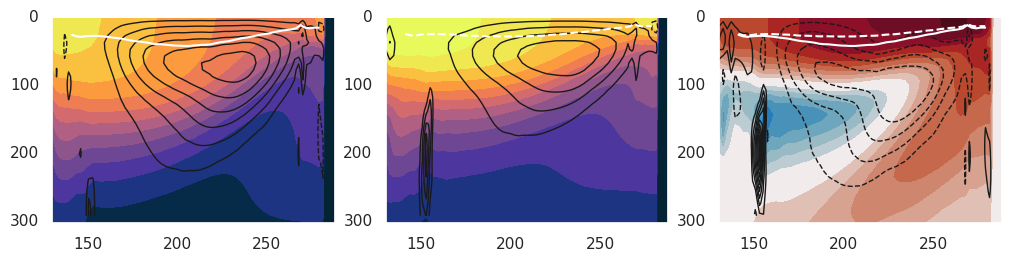

In [252]:
## specify which period/month to plot
sel = lambda x: x.mean("month")
# sel = lambda x: x.sel(month=5)

fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), layout="constrained")

for ax, clim in zip(axs[:2], [clim_sub_early, clim_sub_late]):

    ## temperature
    ax.contourf(
        clim["T"].lon,
        clim["T"].z_t / 100,
        sel(clim["T"]),
        cmap="cmo.thermal",
        levels=np.arange(10, 34, 2),
        extend="both",
    )

    ## vertical velocity
    ax.contour(
        clim["w"].lon,
        clim["w"].z_w_top / 100,
        sel(clim["w"]),
        colors="k",
        levels=src.utils.make_cb_range(10, 1),
        extend="both",
        linewidths=1,
    )


## plot difference
diff = clim_sub_late - clim_sub_early

## temperature
axs[2].contourf(
    clim["T"].lon,
    clim["T"].z_t / 100,
    sel(diff["T"]),
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(5, 0.5),
    extend="both",
)

## vertical velocity
axs[2].contour(
    clim["w"].lon,
    clim["w"].z_w_top / 100,
    sel(diff["w"]),
    colors="k",
    levels=src.utils.make_cb_range(5, 0.5),
    extend="both",
    linewidths=1,
)

## plot MLD
axs[0].plot(eq_mld_early.longitude, sel(eq_mld_early), c="w")
axs[1].plot(eq_mld_late.longitude, sel(eq_mld_late), c="w", ls="--")
axs[2].plot(eq_mld_early.longitude, sel(eq_mld_early), c="w")
axs[2].plot(eq_mld_late.longitude, sel(eq_mld_late), c="w", ls="--")


for ax in axs:
    ax.set_ylim(ax.get_ylim()[::-1])

plt.show()

#### Hovmoller

In [ ]:
def get_w_int(w):
    """get vertical velocity integrated over top 200 m"""
    return w.sel(z_w_top=slice(None, 20000)).mean("z_w_top")


def get_dTdz(Tsub):
    """get vertical velocity integrated over top 200 m"""
    T_surf = Tsub.sel(z_t=0, method="nearest").squeeze(drop=True)
    T_subsurf = Tsub.sel(z_t=20000, method="nearest").squeeze(drop=True)

    return T_surf - T_subsurf


def get_diags(data):
    """get diagnostics"""
    diags = xr.merge(
        [get_dTdz(data["T"]).rename("dTdz"), get_w_int(data["w"]).rename("w_int")]
    )
    return diags.rename({"lon": "longitude"})

In [ ]:
## get diagnostics
diags_early = get_diags(clim_sub_early)
diags_late = get_diags(clim_sub_late)
diags_diff = diags_late - diags_early

##### Stratification

In [ ]:
## make hövmöllers
fig, axs = plt.subplots(3, 1, figsize=(3.5, 5), layout="constrained")

## kwargs
kwargs = dict(cmap="cmo.amp", levels=np.arange(10, 19, 1), extend="both")

## plot early
cp0 = src.utils.plot_cycle_hov(axs[0], diags_early["dTdz"], **kwargs)

# ## plot late
cp1 = src.utils.plot_cycle_hov(axs[1], diags_late["dTdz"], **kwargs)

## plot difference
cp2 = src.utils.plot_cycle_hov(
    axs[2],
    diags_diff["dTdz"],
    cmap="cmo.amp",
    levels=np.arange(0, 6.6, 0.6),
    extend="both",
)

## label
axs[0].set_title("Early")
axs[1].set_title("Late")
axs[2].set_title("Difference")
axs[-1].set_xlabel("Longitude")
axs[-1].set_xticks([140, 190, 240])

cb0 = fig.colorbar(cp0, ax=axs[0], ticks=[10, 14, 18], label=r"$^{\circ}C$")
cb1 = fig.colorbar(cp1, ax=axs[1], ticks=[10, 14, 18], label=r"$^{\circ}C$")
cb2 = fig.colorbar(cp2, ax=axs[2], ticks=[0, 3, 6], label=r"$^{\circ}C$")

plt.show()

##### Temperature gradient

In [ ]:
## make hövmöllers
fig, axs = plt.subplots(3, 1, figsize=(3.5, 5), layout="constrained")

## kwargs
kwargs = dict(
    cmap="cmo.balance", levels=src.utils.make_cb_range(5.25, 0.75), extend="both"
)

## plot early
cp0 = src.utils.plot_cycle_hov(axs[0], diags_early["w_int"], **kwargs)

# ## plot late
cp1 = src.utils.plot_cycle_hov(axs[1], diags_late["w_int"], **kwargs)

# ## plot difference
cp2 = src.utils.plot_cycle_hov(
    axs[2],
    diags_diff["w_int"],
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(2.5, 0.5),
    extend="both",
)

## label
axs[0].set_title("Early")
axs[1].set_title("Late")
axs[2].set_title("Difference")
axs[-1].set_xlabel("Longitude")
axs[-1].set_xticks([140, 190, 240])

cb0 = fig.colorbar(cp0, ax=axs[0], ticks=[0, 5], label=r"$m/hr$")
cb1 = fig.colorbar(cp1, ax=axs[1], ticks=[0, 5], label=r"$m/hr$")
cb2 = fig.colorbar(cp2, ax=axs[2], ticks=[-2.5, 0, 2.5], label=r"$m/hr$")

plt.show()

##### vertical temperature flux
\begin{align}
    \overline{w}/\overline{H}
\end{align}

##### Functions to use in computation

In [ ]:
def get_w_sub(w, mld):
    """get velocity at base of mixed layer"""

    ## interpolate mld to match w
    mld_interp = mld.interp({"longitude": w.lon})

    ## subset for non-NaN coords
    valid_lon_idx = ~np.isnan(mld_interp).all("month")
    mld_interp = mld_interp.isel(nlon=valid_lon_idx)
    w = w.isel(nlon=valid_lon_idx)

    ## get w along section
    w_sub = []
    for i, lon_ in enumerate(w.lon):
        mld_ = mld_interp.isel(nlon=i).drop_vars("nlon")
        w_ = w.isel(nlon=i).drop_vars("nlon")
        # w_sub.append(w_.sel(z_w_top=mld_, method="nearest"))
        w_sub.append(w_.interp(z_w_top=mld_ * 100))

    return xr.concat(w_sub, dim=pd.Index(w.lon.values, name="lon"))


def get_v_timescale(w, mld):
    """get inverse timescale for mean upwelling (w/H)"""

    ## interpolate mld to match w
    mld_interp = mld.interp({"longitude": w.lon})

    ## get w at base of ML
    w_sub = get_w_sub(w, mld)

    ## set negative values to zero
    w_sub = w_sub.where(w_sub > 0, other=0)

    ## compute
    return w_sub / mld.interp({"longitude": w_sub.lon})

##### Compute

In [ ]:
## get vertical velocities
w_sub_early = get_w_sub(w=clim_sub_early["w"], mld=eq_mld_early)
w_sub_late = get_w_sub(w=clim_sub_late["w"], mld=eq_mld_late)

## get (inverse) upwelling timescale
t_inv_early = get_v_timescale(w=clim_sub_early["w"], mld=eq_mld_early)
t_inv_late = get_v_timescale(w=clim_sub_late["w"], mld=eq_mld_late)

## get pct_change
t_inv_diff = t_inv_late - t_inv_early
t_inv_diff_pct = 100 * t_inv_diff / t_inv_early

##### Plot for single month

In [ ]:
## select
sel = lambda x: x.mean("month")

fig, axs = plt.subplots(1, 3, figsize=(5, 1.5), layout="constrained")

axs[0].plot(eq_mld_early.longitude, sel(eq_mld_early))
axs[0].plot(eq_mld_late.longitude, sel(eq_mld_late))

axs[1].plot(w_sub_early.lon, sel(w_sub_early))
axs[1].plot(w_sub_early.lon, sel(w_sub_late))

axs[2].plot(t_inv_early.lon, sel(t_inv_early))
axs[2].plot(t_inv_late.lon, sel(t_inv_late))

axs[0].set_ylim(axs[0].get_ylim()[::-1])

plt.show()

Hovmoller version of plot

In [ ]:
## make hövmöllers
fig, axs = plt.subplots(3, 1, figsize=(3.5, 5), layout="constrained")

## kwargs
kwargs = dict(cmap="cmo.amp", levels=np.arange(0, 0.22, 0.02), extend="max")

## plot early
cp0 = src.utils.plot_cycle_hov(axs[0], t_inv_early, **kwargs)

# ## plot late
cp1 = src.utils.plot_cycle_hov(axs[1], t_inv_late, **kwargs)

## plot difference
cp2 = src.utils.plot_cycle_hov(
    axs[2],
    t_inv_diff,
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(0.1, 0.01),
    extend="both",
)

## label
axs[0].set_title("Early")
axs[1].set_title("Late")
axs[2].set_title("Difference")
axs[-1].set_xlabel("Longitude")
axs[-1].set_xticks([140, 190, 240])

cb0 = fig.colorbar(cp0, ax=axs[0], ticks=[0, 0.2], label=r"$hr^{-1}$")
cb1 = fig.colorbar(cp1, ax=axs[1], ticks=[0, 0.2], label=r"$hr^{-1}$")
cb2 = fig.colorbar(cp2, ax=axs[2], ticks=[-0.1, 0.1], label=r"$hr^{-1}$")

plt.show()

Look at temperature gradient more carefully

In [ ]:
def get_dTdz_sub(Tsub, mld):
    """get velocity at base of mixed layer"""

    ## interpolate mld to match w
    mld_interp = mld.interp({"longitude": Tsub.lon})

    ## subset for non-NaN coords
    valid_lon_idx = ~np.isnan(mld_interp).all("month")
    mld_interp = mld_interp.isel(nlon=valid_lon_idx)
    Tsub = Tsub.isel(nlon=valid_lon_idx)

    ## convert mld_interp to units of Tsub.z_t
    mld_interp *= 100

    ## find indices in ML and entrainment zone (ez)
    in_ml = Tsub.z_t <= mld_interp
    in_ez = (Tsub.z_t > mld_interp) & (Tsub.z_t < (2500 + mld_interp))

    ## get Tbar and Tplus (following Frankignoul et al paper)
    Tbar = Tsub.where(in_ml).mean("z_t")
    Tplus = Tsub.where(in_ez).mean("z_t")

    ## get gradient
    dTdz = (Tbar - Tplus) / mld_interp

    ## convert from K/cm to K/m
    dTdz *= 100

    return dTdz

In [ ]:
## get vertical velocities
dTdz_early = get_dTdz_sub(Tsub=clim_sub_early["T"], mld=eq_mld_early)
dTdz_late = get_dTdz_sub(Tsub=clim_sub_late["T"], mld=eq_mld_late)

In [ ]:
## make hövmöllers
fig, axs = plt.subplots(3, 1, figsize=(3.5, 5), layout="constrained")

## kwargs
kwargs = dict(cmap="cmo.amp", levels=np.arange(0, 0.3, 0.03), extend="max")

## plot early
cp0 = src.utils.plot_cycle_hov(axs[0], dTdz_early, **kwargs)

# ## plot late
cp1 = src.utils.plot_cycle_hov(axs[1], dTdz_late, **kwargs)

## plot difference
cp2 = src.utils.plot_cycle_hov(
    axs[2],
    dTdz_late - dTdz_early,
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(0.15, 0.015),
    extend="both",
)

## label
axs[0].set_title("Early")
axs[1].set_title("Late")
axs[2].set_title("Difference")
axs[-1].set_xlabel("Longitude")
axs[-1].set_xticks([140, 190, 240])

cb0 = fig.colorbar(cp0, ax=axs[0], ticks=[0, 0.3], label=r"$K~m^{-1}$")
cb1 = fig.colorbar(cp1, ax=axs[1], ticks=[0, 0.3], label=r"$K~m^{-1}$")
cb2 = fig.colorbar(cp2, ax=axs[2], ticks=[-0.15, 0.15], label=r"$K~m^{-1}$")

plt.show()

#### Change over time

In [ ]:
def get_nino34(data):
    return data.sel(lon=slice(190, 240)).mean("lon")


def get_w_int_idx(data):
    """get nino3.4 w-int"""
    return get_nino34(get_w_int(data))


def get_dTdz_idx(data):
    """get nino3.4 w-int"""
    return get_nino34(get_dTdz(data))


def reconstruct_fn(components, scores, fn):

    ## reconstruct
    recon = (fn(components) * scores).sum("mode")

    return recon

Compute indices

In [ ]:
## compute indices
w_idx = reconstruct_fn(components_sub["w"], forced_sub["w"], get_w_int_idx)
dTdz_idx = reconstruct_fn(components_sub["T"], forced_sub["T"], get_dTdz_idx)

## merge
idxs = xr.merge([w_idx.rename("w"), dTdz_idx.rename("dTdz")])

## unstack month and year, and get percent change
idxs = src.utils.unstack_month_and_year(idxs)
idxs = src.utils.get_rolling_avg(idxs, n=15, dim="year")
delta_idxs = idxs - idxs.isel(year=0)

Hovmoller indices

In [ ]:
## setup plot
fig, axs = plt.subplots(1, 2, figsize=(2, 3), layout="constrained")

## plot mean
plot_hov2(axs[0], delta_idxs["dTdz"].T, amp=4)
plot_hov2(axs[1], delta_idxs["w"].T, amp=2)

## label
kwargs = dict(size=12)
axs[0].set_title(r"$\Delta \frac{\partial T}{\partial z}$", **kwargs)
axs[1].set_title(r"$\Delta w$", **kwargs)

plt.show()

### Change in variance

#### Equatorial region

In [ ]:
def eq_avg(x):
    return x.sel(latitude=slice(-5, 5), longitude=slice(125, 279)).mean("latitude")


def get_var(data, year_center, n=15, fn=None):
    """
    Reconstruct variance for given time period.
    Estimate variance based on window centered on `year_center'.
    Window encompasses all samples within 'n' years of year_center.
    """

    ## get indices of samples in window
    in_window = np.abs(data.time.dt.year - year_center) <= n

    ## get variance of samples in window
    kwargs = dict(components=components, scores=data.isel(time=in_window), fn=fn)
    data_var = src.utils.reconstruct_var(**kwargs)

    return data_var


def get_var_bymonth(data, year_center, n=15, fn=None):
    """Get variance by month"""

    ## function to apply to each month
    kwargs = dict(year_center=year_center, n=n, fn=fn)
    get_var_ = lambda x: get_var(x, **kwargs)
    return data.groupby("time.month").map(get_var_)


def get_var_for_periods(data, periods, n=15, fn=None, by_month=True):
    """get variance for specified periods"""

    ## get arguments for variance reconstruction
    kwargs = dict(data=data, n=n, fn=fn)

    ## get variance recon func
    get_var_fn = get_var_bymonth if by_month else get_var
    var_by_period = [get_var_fn(year_center=y, **kwargs) for y in tqdm.tqdm(periods)]

    ## get dimension to represent period_centers
    period_dim = pd.Index(periods, name="period")

    ## put in array
    return xr.concat(var_by_period, dim=period_dim)


## get variance by period
period_centers = np.array([1868, 2082])

## Get equatorial strip variance
kwargs = dict(data=anom, periods=period_centers, n=15, fn=eq_avg)
var_by_period_eq = get_var_for_periods(**kwargs)

## get full variance
kwargs = dict(kwargs, fn=None, periods=period_centers[[0, -1]], by_month=True)
var_by_period = get_var_for_periods(**kwargs)

#### Spatial (Hovmoller)

In [ ]:
## get plot data
baseline = var_by_period_eq["sst"].isel(period=0)
future = var_by_period_eq["sst"].isel(period=-1)
change = future - baseline

## shared args for plotting
plot_kwargs = dict(cmap="cmo.amp", extend="max")

## Set up plot
fig, axs = plt.subplots(3, 1, figsize=(4, 6), layout="constrained")

## make hövmöllers
cp0 = src.utils.plot_cycle_hov(
    axs[0], baseline, levels=np.arange(0, 3.3, 0.3), **plot_kwargs
)
cp1 = src.utils.plot_cycle_hov(
    axs[1], future, levels=np.arange(0, 3.3, 0.3), **plot_kwargs
)
cp2 = src.utils.plot_cycle_hov(
    axs[2],
    change,
    levels=src.utils.make_cb_range(1.5, 0.15),
    cmap="cmo.balance",
    extend="both",
)

## label
axs[0].set_title("Baseline")
axs[1].set_title("Future")
axs[2].set_title("Difference")
axs[-1].set_xlabel("Longitude")
axs[-1].set_xticks([140, 190, 240])

## add colorbars
kwargs = dict(ticks=[0, 1, 2, 3], label=r"$^{\circ}\text{C}^2$")
cb0 = fig.colorbar(cp0, ax=axs[0], **kwargs)
cb1 = fig.colorbar(cp1, ax=axs[1], **kwargs)
cb2 = fig.colorbar(cp2, ax=axs[2], **dict(kwargs, ticks=[-1.5, 0, 1.5]))

plt.show()

#### Spatial

Compute

In [ ]:
## specify month
month = 9

## set up paneled subplot
fig = plt.figure(figsize=(6, 5), layout="constrained")
axs = src.utils.subplots_with_proj(
    fig, nrows=3, ncols=1, format_func=src.utils.plot_setup_pac
)

## plot data
kwargs = dict(
    var0=var_by_period["sst"].isel(period=0).sel(month=month),
    var1=var_by_period["sst"].isel(period=-1).sel(month=month),
    amp=3.5,
    amp_diff=1,
    show_colorbars=True,
    cbar_label=r"$^{\circ}$C$^2$",
)
fig, axs = src.utils.make_variance_subplots(fig, axs, **kwargs)
axs[0, 0].set_title("Early (1853 – 1883)")
axs[1, 0].set_title("Late (2067 – 2097)")
axs[2, 0].set_title("Difference")

for ax in axs.flatten():
    src.utils.plot_nino34_box(ax, c="w")

plt.show()

#### ENSO composite

Function to compute composite

In [ ]:
def get_hov_composite(data, peak_month, q, idx_fn, is_warm=True):
    """
    Get hovmoller composite based on specified:
    - data: used to compute index/make composite
    - peak_month: month to center composite on
    - q: quantile threshold for composite
    - idx_fn: function to compute index from spatial sst anoms
    """

    ## get data subset

    ## get index
    idx = src.utils.reconstruct_fn(
        components=components["sst"], scores=data["sst"], fn=idx_fn
    )

    ## handle warm/cold case
    if is_warm:
        kwargs = dict(q=q, check_cutoff=lambda x, cut: x > cut)
    else:
        kwargs = dict(q=1 - q, check_cutoff=lambda x, cut: x < cut)

    ## kwargs for composite
    kwargs = dict(kwargs, peak_month=peak_month, idx=idx, data=data)

    ## composite of projected data
    comp_proj = src.utils.make_composite(**kwargs)

    ## fn to get meridional mean
    lat = dict(latitude=slice(-5, 5))
    get_merimean = lambda x: x.sel(lat).mean("latitude")

    ## meridional mean for MPI
    comp_merimean = src.utils.reconstruct_fn(
        components=components, scores=comp_proj, fn=get_merimean
    ).transpose("lag", ...)

    return comp_merimean

Do the computation

In [ ]:
## specify shared args
kwargs = dict(
    peak_month=12,
    q=0.95,
    idx_fn=src.utils.get_nino34,
    is_warm=True,
)

## get early/late composites
comp_early = get_hov_composite(anom.isel(time=slice(None, 360)), **kwargs)
comp_late = get_hov_composite(anom.isel(time=slice(-361, -1)), **kwargs)

Plot the result

In [ ]:
## specify amplitudes for plots
scales = np.array([1.5, 1.5, 0.5])

## set up plot
fig, axs = plt.subplots(1, 3, figsize=(6, 3), layout="constrained")

for ax, merimean, scale in zip(
    axs, [comp_early, comp_late, comp_late - comp_early], scales
):
    cf, _ = src.utils.plot_hov(ax=ax, x=merimean, beta=scale)
    ax.set_xticks([])
    ax.set_yticks([])

    ## label x axis
    ax.set_xlabel("Longitude")
    ax.set_xticks([190, 240])
    ax.set_yticks([])

## label
axs[0].set_title("Early (1853-1883)")
axs[1].set_title("Late (2067-2097)")
axs[2].set_title("Difference")
src.utils.label_hov_yaxis(axs[0], peak_mon=kwargs["peak_month"])

plt.show()

### Change in Bjerknes coupling

#### Hövmöller

In [ ]:
def get_alpha(data, dim):
    """compute mu: linear dependence of nhf on sst"""

    return src.utils.regress_core(Y=data["nhf"], X=data["sst"], dim=dim)


def get_mu(data, dim):
    """compute mu: linear dependence of taux on sst"""

    return src.utils.regress_core(Y=data["taux"], X=data["sst"], dim=dim)


def get_beta(data, dim):
    """compute mu: linear dependence of ssh on taux"""

    return src.utils.regress_core(Y=data["ssh"], X=data["taux"], dim=dim)


def get_xi(data, dim):
    """compute mu: linear dependence of sst on ssh"""

    return src.utils.regress_core(Y=data["sst"], X=data["ssh"], dim=dim)


def get_params(data, dim="time"):
    """compute all parameters"""
    params = xr.merge(
        [
            get_alpha(data, dim=dim).rename("alpha"),
            get_mu(data, dim=dim).rename("mu"),
            get_beta(data, dim=dim).rename("beta"),
            get_xi(data, dim=dim).rename("xi"),
        ]
    )

    params["coupling"] = params["mu"] * params["beta"] * params["xi"]

    return params


def get_rolling_params(data, n=10, reduce_ensemble=True):
    """get rolling parameters"""

    ## get rolling data
    idx_rolling = data.rolling({"time": 2 * n + 1}, center=True)

    ## expand rolling object along "window" dimension
    idx_rolling = idx_rolling.construct("window")

    ## stack member/window if desired
    if reduce_ensemble:
        idx_rolling = idx_rolling.stack(sample=["member", "window"])

    else:
        idx_rolling = idx_rolling.rename({"window": "sample"})

    return get_params(idx_rolling, dim="sample")


def get_rolling_params_bymonth(data, **kwargs):
    """get rolling parameters for each month separately..."""

    return data.groupby("time.month").map(get_rolling_params, **kwargs)


def get_fractional_change(data, dim="year"):
    clim = data.isel({dim: slice(None, 30)}).mean(dim)

    return (data - clim) / clim

In [ ]:
## compute indices
kwargs = dict(scores=anom, components=components)
nino34 = src.utils.reconstruct_fn(fn=src.utils.get_nino34, **kwargs)
nino4 = src.utils.reconstruct_fn(fn=src.utils.get_nino4, **kwargs)

## subset for relevant indices
idxs = xr.merge([nino34[["sst", "nhf", "ssh"]], nino4["taux"]])

In [ ]:
## get params over time
params = get_rolling_params_bymonth(idxs, n=16)

## unstack month and year to separate dims
params = src.utils.unstack_month_and_year(params)

## subtract off climatology
delta_params = params - params.isel(year=slice(None, 30)).mean("year")

In [ ]:
## setup plot
fig, axs = plt.subplots(1, 5, figsize=(9, 4), layout="constrained")

## plot T data
plot_hov2(axs[0], delta_params["alpha"].T, amp=20, label=r"$\Delta~ \alpha$")
plot_hov2(axs[1], delta_params["mu"].T, amp=0.01, label=r"$\tau_x-\text{SST}$")
plot_hov2(axs[2], delta_params["beta"].T, amp=200, label=r"$\text{SSH}-\tau_x$")
plot_hov2(axs[3], delta_params["xi"].T, amp=7e-2, label=r"$\text{SST}-\text{SSH}$")
plot_hov2(axs[4], delta_params["coupling"].T, amp=0.5, label=r"coupling")

for ax in axs:
    ax.axvline(7, c="k", lw=1, ls="--")

## label
axs[0].set_yticks(np.linspace(1870, 2082, 5))
axs[0].set_ylabel("Year")
axs[1].set_ylim(axs[0].get_ylim())
plt.show()

#### Spatial pattern/seasonal cycle

In [ ]:
def merimean(x):
    return x.sel(longitude=slice(140, 285), latitude=slice(-5, 5)).mean("latitude")


def plot_cycle_hov(ax, data, amp, is_filled=True):
    """plot data on ax object"""

    ## specify shared kwargs
    shared_kwargs = dict(levels=src.utils.make_cb_range(amp, amp / 5), extend="both")

    ## specify kwargs
    if is_filled:
        plot_fn = ax.contourf
        kwargs = dict(cmap="cmo.balance")

    else:
        plot_fn = ax.contour
        kwargs = dict(colors="k", linewidths=0.8)

    ## do the plotting
    cp = plot_fn(
        merimean(data).longitude,
        merimean(data).month,
        merimean(data),
        **kwargs,
        **shared_kwargs,
    )

    ## format ax object
    xticks = [160, 210]
    kwargs = dict(c="w", ls="--", lw=1)
    ax.set_xlabel("Lon")
    ax.set_xticks(xticks)
    for tick in xticks:
        ax.axvline(tick, **kwargs)

    return cp

Add EOF info to dataset

In [ ]:
for v in list(components):
    if f"{v}_comp" not in list(anom):
        anom[f"{v}_comp"] = components[v]

## add nino3 to data
names = ["nino3", "nino34", "nino4"]
fns = [src.utils.get_nino3, src.utils.get_nino34, src.utils.get_nino4]
for n, fn in zip(names, fns):
    if n not in list(anom):
        anom[n] = src.utils.reconstruct_fn(
            scores=anom["sst"], components=anom["sst_comp"], fn=fn
        )

Partition into early/late

In [ ]:
anom_early = anom.isel(time=slice(12, 372))
anom_late = anom.isel(time=slice(-372, -12))

#### $\tau_x$-SST

Compute slope

In [ ]:
## shared kwargs
kwargs = dict(x_var="sst", y_var="taux", fn_x=src.utils.get_nino34)

## function to get slope
get_slope = lambda x: x.groupby("time.month").map(src.utils.regress_proj, **kwargs)

## then, reconstruct regression coefficient
m_early = get_slope(anom_early)
m_late = get_slope(anom_late)

Plot hovmoller

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2.5), layout="constrained")

## plot data
cp0 = plot_cycle_hov(axs[0], data=m_early, amp=0.015)
plot_cycle_hov(axs[0], data=m_late, amp=0.015, is_filled=False)

## plot difference
cp2 = plot_cycle_hov(axs[1], data=m_late - m_early, amp=0.0075)

## make it look nicer
axs[1].set_yticks([])
axs[0].set_yticks([1, 5, 9, 12], labels=["Jan", "May", "Sep", "Dec"])
axs[0].set_ylabel("Month")
axs[0].set_title(r"$\tau_x$-SST coupling")
axs[1].set_title("Change")

plt.show()

##### Explained variance

In [ ]:
def regress_helper(data):
    """helper function for regression"""

    ## stack data
    data_stack = data.stack(sample=["member", "time"])

    ## kwargs for regression
    kwargs = dict(X=data_stack["nino3"], Y=data_stack["taux"], dim="sample")

    return src.utils.regress_core(**kwargs)


def get_recon_skill(data):
    """get reconstruction error"""

    ## get coefficients
    m = regress_helper(data)

    ## get reconstruction
    recon = data["nino34"] * m

    ## reconstruct correlation
    cov = src.utils.reconstruct_cov_da(
        V_x=recon,
        V_y=data["taux"],
        U_x=data["taux_comp"],
        U_y=data["taux_comp"],
    )
    var = src.utils.reconstruct_var(
        scores=data["taux"],
        components=data["taux_comp"],
    )

    return cov / var


## function to get correlation
get_skill = lambda x: x.groupby("time.month").map(get_recon_skill)

## then, reconstruct regression coefficient
r_early = get_skill(anom_early)
r_late = get_skill(anom_late)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2.5), layout="constrained")

## plot data
cp0 = plot_cycle_hov(axs[0], data=r_early, amp=0.8)
plot_cycle_hov(axs[0], data=r_late, amp=0.8, is_filled=False)

## plot difference
cp2 = plot_cycle_hov(axs[1], data=r_late - r_early, amp=0.4)

## make it look nicer
axs[1].set_yticks([])
axs[0].set_yticks([1, 5, 9, 12], labels=["Jan", "May", "Sep", "Dec"])
axs[0].set_ylabel("Month")
axs[0].set_title(r"Correlation")
axs[1].set_title("Change")

plt.show()

#### Heat flux

In [ ]:
## shared kwargs
kwargs = dict(x_var="sst", y_var="nhf", fn_x=src.utils.get_nino34)
# kwargs = dict(x_var="sst", y_var="nhf")

## function to get slope
get_slope = lambda x: x.groupby("time.month").map(src.utils.regress_proj, **kwargs)

## then, reconstruct regression coefficient
m_early = get_slope(anom_early)
m_late = get_slope(anom_late)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2.5), layout="constrained")

## plot data
cp0 = plot_cycle_hov(axs[0], data=m_early, amp=40)
plot_cycle_hov(axs[0], data=m_late, amp=40, is_filled=False)

## plot difference
cp2 = plot_cycle_hov(axs[1], data=m_late - m_early, amp=20)

## make it look nicer
axs[1].set_yticks([])
axs[0].set_yticks([1, 5, 9, 12], labels=["Jan", "May", "Sep", "Dec"])
axs[0].set_ylabel("Month")
axs[0].set_title(r"NHF-SST coupling")
axs[1].set_title("Change")

plt.show()

#### SST-SSH

In [ ]:
## shared kwargs
kwargs = dict(x_var="ssh", y_var="sst")

## function to get slope
get_slope = lambda x: x.groupby("time.month").map(src.utils.regress_proj, **kwargs)

## then, reconstruct regression coefficient
m_early = get_slope(anom_early)
m_late = get_slope(anom_late)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2.5), layout="constrained")

## plot data
cp0 = plot_cycle_hov(axs[0], data=m_early, amp=0.3)
plot_cycle_hov(axs[0], data=m_late, amp=0.3, is_filled=False)

## plot difference
cp2 = plot_cycle_hov(axs[1], data=m_late - m_early, amp=0.15)

## make it look nicer
axs[1].set_yticks([])
axs[0].set_yticks([1, 5, 9, 12], labels=["Jan", "May", "Sep", "Dec"])
axs[0].set_ylabel("Month")
axs[0].set_title(r"SST-SSH coupling")
axs[1].set_title("Change")

plt.show()

#### $\tau_x$-SST asymmetry

In [ ]:
def regress_relu(data, is_pos=True):
    """regress on function for positive values of nino3"""

    ## stack data
    data = data.stack(sample=["member", "time"])

    ## find which indices to keep
    if is_pos:
        idx = data["nino3"] > 0
    else:
        idx = data["nino3"] < 0

    ## select valid values of idx
    data_idx = data.where(idx, other=0)

    ## do regression
    return src.utils.regress_core(Y=data_idx["taux"], X=data_idx["nino3"], dim="sample")


def regress_relu_wrapper(data, eofs):
    """wrapper function"""

    ## get nino3
    nino3 = src.utils.reconstruct_fn(
        components=eofs["sst"].components(), scores=data["sst"], fn=src.utils.get_nino3
    )

    ## new array
    taux = xr.merge([data["taux"], nino3.rename("nino3")])

    ## compute regression coefs
    m_pos = eofs["taux"].inverse_transform(
        taux.groupby("time.month").map(regress_relu, is_pos=True)
    )

    m_neg = eofs["taux"].inverse_transform(
        taux.groupby("time.month").map(regress_relu, is_pos=False)
    )

    return m_pos - m_neg

Compute

In [ ]:
asym_early = regress_relu_wrapper(anom_early, eofs)
asym_late = regress_relu_wrapper(anom_late, eofs)

Plot

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2.5), layout="constrained")

## plot data
cp0 = plot_cycle_hov(axs[0], data=asym_early, amp=0.0075)
# plot_cycle_hov(axs[0], data=asym_late, amp=0.0075, is_filled=False)
cp2 = plot_cycle_hov(axs[1], data=asym_late, amp=0.0075)

## make it look nicer
axs[1].set_yticks([])
axs[0].set_yticks([1, 5, 9, 12], labels=["Jan", "May", "Sep", "Dec"])
axs[0].set_ylabel("Month")

axs[0].set_title("Early asym.")
axs[1].set_title("Late asym.")

plt.show()

#### Subsurface stuff

In [ ]:
## add components to dataset
for v in list(components_sub):
    if f"{v}_comp" not in list(anom_sub):
        anom_sub[f"{v}_comp"] = components_sub[v]

## add sst to dataset
if "sst" not in list(anom_sub):
    anom_sub["sst"] = anom["sst"].isel(time=slice(1, None))
    anom_sub["sst_comp"] = anom["sst_comp"]

## split into early/late periods
anom_sub_early = anom_sub.isel(time=slice(None, 360))
anom_sub_late = anom_sub.isel(time=slice(-372, -12))

##### First, look at $T_{sub}'$

In [271]:
## shared kwargs
kwargs = dict(x_var="sst", y_var="T", fn_x=src.utils.get_nino34)

## function to get slope
get_slope = lambda x: x.groupby("time.month").map(src.utils.regress_proj, **kwargs)

## then, reconstruct regression coefficient
m_early = get_slope(anom_sub_early)
m_late = get_slope(anom_sub_late)

## get advection term
wT_early = get_wT(w=clim_sub_early["w"], T=m_early)
wT_late = get_wT(w=clim_sub_late["w"], T=m_late)

Plot  

Another idea: plot temperature advection.  
Note: upper ocean response (above ML) is actually weaker in late period: cf. contours at surface b/n early and late periods.

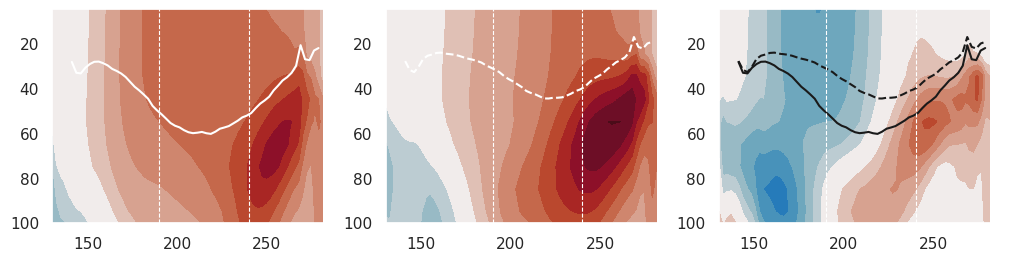

In [272]:
## specify which period/month to plot
# sel = lambda x: x.mean("month")
sel = lambda x: x.sel(month=7)

fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), layout="constrained")

for ax, m in zip(axs[:2], [m_early, m_late]):

    ## temperature
    ax.contourf(
        m.lon,
        m.z_t / 100,
        sel(m),
        cmap="cmo.balance",
        levels=src.utils.make_cb_range(2.5, 0.25),
        extend="both",
    )

## difference
axs[2].contourf(
    m.lon,
    m.z_t / 100,
    sel(m_late - m_early),
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(1.25, 0.125),
    extend="both",
)


## plot subsurface (below ML)
delta = 0

## plot MLD
axs[0].plot(eq_mld_early.longitude, sel(eq_mld_early) + delta, c="w")
axs[1].plot(eq_mld_late.longitude, sel(eq_mld_late) + delta, c="w", ls="--")
axs[2].plot(eq_mld_early.longitude, sel(eq_mld_early) + delta, c="k")
axs[2].plot(eq_mld_early.longitude, sel(eq_mld_late) + delta, c="k", ls="--")

## set ax limit and plot Niño 3.4 bounds
for ax in axs:
    ax.set_ylim([100, 5])
    ax.axvline(190, ls="--", c="w", lw=0.8)
    ax.axvline(240, ls="--", c="w", lw=0.8)

plt.show()

Next, plot $\overline{w}~T_{sub}'$

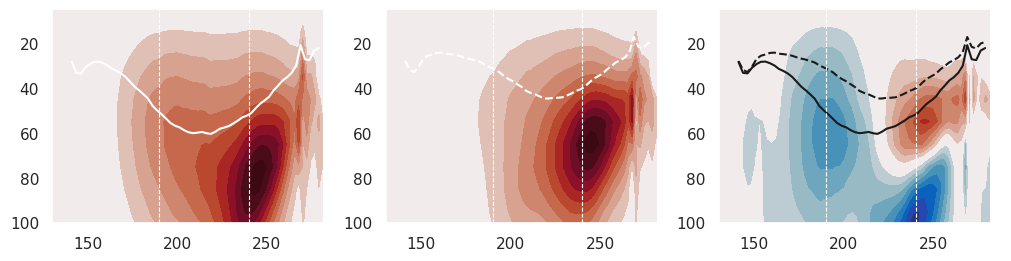

In [273]:
## specify which period/month to plot
sel = lambda x: x.sel(month=7)

fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), layout="constrained")

for ax, wT in zip(axs[:2], [wT_early, wT_late]):

    ## temperature
    ax.contourf(
        wT.lon,
        wT.z_t / 100,
        sel(wT),
        cmap="cmo.balance",
        levels=src.utils.make_cb_range(10, 1),
        extend="both",
    )

## difference
axs[2].contourf(
    wT.lon,
    wT.z_t / 100,
    sel(wT_late - wT_early),
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(5, 0.5),
    extend="both",
)


## plot subsurface (below ML)
delta = 0

## plot MLD
axs[0].plot(eq_mld_early.longitude, sel(eq_mld_early) + delta, c="w")
axs[1].plot(eq_mld_late.longitude, sel(eq_mld_late) + delta, c="w", ls="--")
axs[2].plot(eq_mld_early.longitude, sel(eq_mld_early) + delta, c="k")
axs[2].plot(eq_mld_early.longitude, sel(eq_mld_late) + delta, c="k", ls="--")

## set ax limit and plot Niño 3.4 bounds
for ax in axs:
    ax.set_ylim([100, 5])
    ax.axvline(190, ls="--", c="w", lw=0.8)
    ax.axvline(240, ls="--", c="w", lw=0.8)

plt.show()

##### Next, look at $w'$

In [274]:
## shared kwargs
kwargs = dict(x_var="sst", y_var="w", fn_x=src.utils.get_nino34)

## function to get slope
get_slope = lambda x: x.groupby("time.month").map(src.utils.regress_proj, **kwargs)

## drop 60th ensemble member: NaN values
valid_member_idx = np.concatenate([np.arange(0, 60), np.arange(61, 100)])

## then, reconstruct regression coefficient
m_early = get_slope(anom_sub_early.isel(member=valid_member_idx))
m_late = get_slope(anom_sub_late.isel(member=valid_member_idx))

## get advection
wT_early = get_wT(w=m_early, T=clim_sub_early["T"])
wT_late = get_wT(w=m_late, T=clim_sub_late["T"])

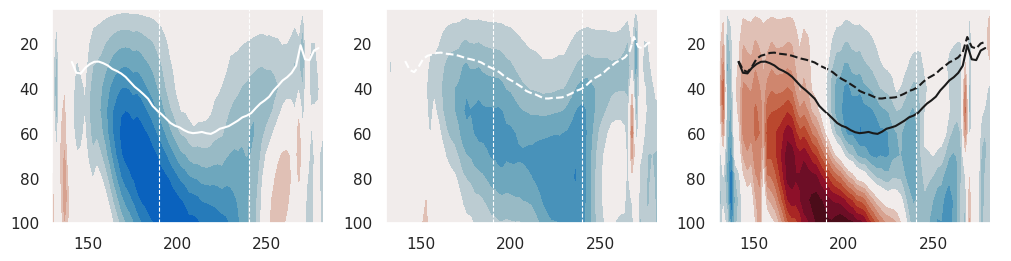

In [268]:
## specify which period/month to plot
# sel = lambda x: x.mean("month")
sel = lambda x: x.sel(month=7)

fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), layout="constrained")

for ax, m in zip(axs[:2], [m_early, m_late]):

    ## temperature
    ax.contourf(
        m.lon,
        m.z_w_top / 100,
        sel(m),
        cmap="cmo.balance",
        levels=src.utils.make_cb_range(2.5, 0.25),
        extend="both",
    )

## difference
axs[2].contourf(
    m.lon,
    m.z_w_top / 100,
    sel(m_late - m_early),
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(1.25, 0.125),
    extend="both",
)


## plot subsurface (below ML)
delta = 0

## plot MLD
axs[0].plot(eq_mld_early.longitude, sel(eq_mld_early) + delta, c="w")
axs[1].plot(eq_mld_late.longitude, sel(eq_mld_late) + delta, c="w", ls="--")
axs[2].plot(eq_mld_early.longitude, sel(eq_mld_early) + delta, c="k")
axs[2].plot(eq_mld_early.longitude, sel(eq_mld_late) + delta, c="k", ls="--")

## set ax limit and plot Niño 3.4 bounds
for ax in axs:
    ax.set_ylim([100, 5])
    ax.axvline(190, ls="--", c="w", lw=0.8)
    ax.axvline(240, ls="--", c="w", lw=0.8)

plt.show()

Plot advection

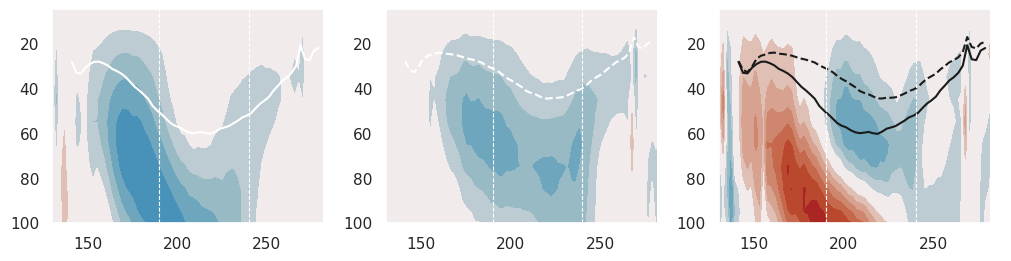

In [276]:
## specify which period/month to plot
sel = lambda x: x.sel(month=7)

fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), layout="constrained")

for ax, wT in zip(axs[:2], [wT_early, wT_late]):

    ## temperature
    ax.contourf(
        wT.lon,
        wT.z_t / 100,
        sel(wT),
        cmap="cmo.balance",
        levels=src.utils.make_cb_range(100, 10),
        extend="both",
    )

## difference
axs[2].contourf(
    wT.lon,
    wT.z_t / 100,
    sel(wT_late - wT_early),
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(50, 5),
    extend="both",
)


## plot subsurface (below ML)
delta = 0

## plot MLD
axs[0].plot(eq_mld_early.longitude, sel(eq_mld_early) + delta, c="w")
axs[1].plot(eq_mld_late.longitude, sel(eq_mld_late) + delta, c="w", ls="--")
axs[2].plot(eq_mld_early.longitude, sel(eq_mld_early) + delta, c="k")
axs[2].plot(eq_mld_early.longitude, sel(eq_mld_late) + delta, c="k", ls="--")

## set ax limit and plot Niño 3.4 bounds
for ax in axs:
    ax.set_ylim([100, 5])
    ax.axvline(190, ls="--", c="w", lw=0.8)
    ax.axvline(240, ls="--", c="w", lw=0.8)

plt.show()

## Change in zonal gradient

### Compute zonal gradient

In [ ]:
def get_zonal_grad(x):
    """
    Function to compute zonal gradient. Ref: Fig 7 in Maher et al, 2023.
    """

    ## outlines for boxes
    ebox_coords = dict(longitude=slice(210, 270), latitude=slice(-5, 5))
    wbox_coords = dict(longitude=slice(120, 180), latitude=slice(-5, 5))

    ## compute box averages
    ebox_avg = src.utils.spatial_avg(x.sel(ebox_coords))
    wbox_avg = src.utils.spatial_avg(x.sel(wbox_coords))

    return ebox_avg - wbox_avg

In [ ]:
## compute zonal gradient
zonal_grad_forced = src.utils.reconstruct_fn(components, forced, fn=get_zonal_grad)

## sep. time into year and month
zonal_grad_forced_bymonth = src.utils.unstack_month_and_year(zonal_grad_forced)

## get change from initial climatology
clim = zonal_grad_forced_bymonth.isel(year=slice(None, 30)).mean("year")
zonal_grad_change = zonal_grad_forced_bymonth - clim

In [ ]:
## setup plot
fig, ax = plt.subplots(figsize=(2, 4), layout="constrained")

## plot data
kwargs = dict(levels=src.utils.make_cb_range(2, 0.2), cmap="cmo.balance")
plot_data = ax.contourf(
    zonal_grad_change.month, zonal_grad_change.year, zonal_grad_change["sst"], **kwargs
)

## label
ax.set_ylabel("Year")
ax.set_xlabel("Month")
ax.set_xticks([1, 6, 12])
ax.set_title(r"$\Delta \left(\partial_x T\right)$")
ax.set_ylim([1950, None])

plt.show()

## Look at mean state-dependence

### Compare Bjerknes growth rate to zonal gradient

#### Load $T,h$ data

In [ ]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

#### Fit RO to $T,h$ data

In [ ]:
## get subset of data
Th_sub = Th.sel(time=slice("1979", "2024"))

## initialize model
model = XRO(ncycle=12, ac_order=3, is_forward=True)

## fit to individual ensemble members
kwargs = dict(model=model, T_var="T_3", h_var="h_w", verbose=True)
_, fits = src.utils.get_RO_ensemble(Th_sub, **kwargs)

## extract parameters
params = model.get_RO_parameters(fits)

#### Look at intra-ensemble spread
$\partial_x T$ vs. BJ index  
Compare to Maher et al (2023)

In [ ]:
## get subset of data to look at
anom_ = anom.sel(time=slice("1979", "2024"))

## compute zonal gradient at every time step
zonal_grad = src.utils.reconstruct_fn(components, anom_, fn=get_zonal_grad)

## get monthly avg
zonal_grad_by_month = zonal_grad.groupby("time.month").mean()

fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(zonal_grad_by_month["sst"].mean("month"), params["R"].mean("cycle"), s=10)
ax.set_xlabel("Zonal SST gradient")
ax.set_ylabel("Bjerknes feedback")
plt.show()